In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
import scipy.optimize as opt

In [82]:
Ea = 84900
R = 8.314
k0 = 2.83e13
def ktemp(T):
    return k0 * np.exp(-Ea / (R * T))

def knatural(T): #this is just natural decay
    k_nat = 0.37 #1/day
    Tref = 293 #K
    thetan = 0.951
    knatT = k_nat * (thetan**(T-Tref))
    return knatT

def ksolar(I, T): #how UV impacts decay
    k_sol = 1.8
    thetas = 1
    Tref = 293
    Icon = I*86400/1e6
    ksT = k_sol*(thetas**(T-Tref))
    ksolday = ksT*Icon
    return ksolday

def kpred(D,T): #filter feeders
    kp = 0.020
    thetap = 1
    Tref = 293
    kpT = kp*(thetap**(T-Tref))
    kpday = kpT*D
    return kpday

def ktot(T,I,D): #total kinetics
    return knatural(T)+ksolar(I, T) + kpred(D,T)

def pkc(ci, cstar, k, tau, P):
    co = cstar + (ci-cstar)/((1 + k*tau/P)**P)
    return co

def pkc_dyman(t, c, ci, cstar, k, tau, P):
    taueffect = tau/P
    dcdt = (1/taueffect) * (ci-c) -k*(c-cstar)
    return [dcdt]
    

#initial parameters
V = 500 
Q = 14
T = 298 #initial values from paper Hernandez-Crespo
Isol = 200
Ddap = 10

tau_tw1 = 5.5
tau_tw2 = 2.6
Vtw1 = Q* tau_tw1
Vtw2 = Q*tau_tw2


ci = 1.7e5 #inlet concentration
ci_tw1 = 1.74e6  # TW1 inlet
ci_tw2 = 1.57e5 
cstar = 100 #background concentration

ktw1 = 2.14
ktw2 = 1.86
thetaTW1 = 0.999
thetaTW2 = 0.983
P = 1 #tanks in series
tau = V/Q
k = ktot(T,Isol, Ddap)

In [85]:
#steady state
co_tw1 = pkc(ci_tw1, cstar, ktw1, tau_tw1, P)
co_tw2 = pkc(ci_tw2, cstar, ktw2, tau_tw2, P)

#removal efficiencies
removal_tw1 = (1 - co_tw1 / ci_tw1) * 100
removal_tw2 = (1 - co_tw2 / ci_tw2) * 100
log_removal_tw1 = np.log10(ci_tw1 / co_tw1)
log_removal_tw2 = np.log10(ci_tw2 / co_tw2)
overall_removal = (1 - co_tw2 / ci) * 100
overall_log_removal = np.log10(ci / co_tw2)

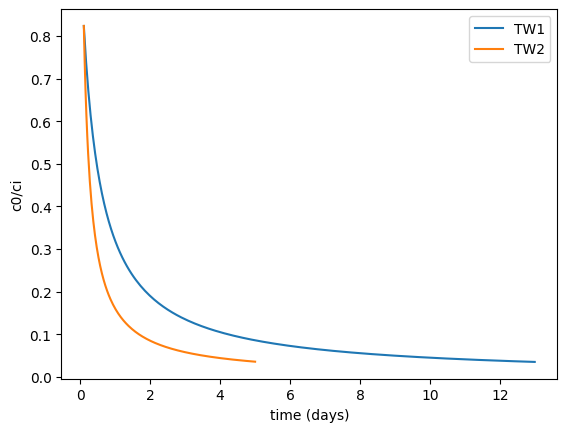

In [107]:
hrt_rangetw1 = np.linspace(0.1, 13, 200)
coci1 = [pkc(ci_tw1, cstar, ktw1, hrt, P)/ci_tw1 for hrt in hrt_rangetw1]
plt.plot(hrt_rangetw1, coci1, label='TW1')

hrt_rangetw2= np.linspace(0.1, 5, 200)
coci2 = [pkc(ci_tw2, cstar, ktw1, hrt, P)/ci_tw2 for hrt in hrt_rangetw1]
plt.plot(hrt_rangetw2, coci2, label='TW2')

plt.xlabel('time (days)')
plt.ylabel('c0/ci')
plt.legend()

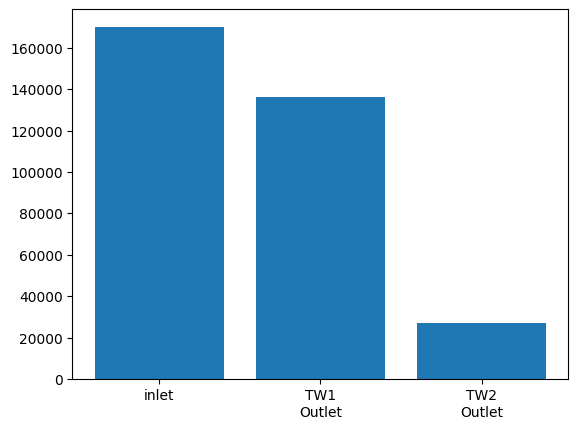

In [100]:
#total system time, and treatment
stages = ['inlet', 'TW1\nOutlet', 'TW2\nOutlet']
conc = [ci, co_tw1, co_tw2]
bars = plt.bar(stages, conc)